# Functions, Constants and  Libs

### Libs

In [1]:
import pandas as pd
import numpy as np
import random
random.seed(10)
from scipy.linalg import cholesky
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm

### Constants

In [2]:
TAU = 1 # treatment effect
CORR = .01 # correlation between covariates
P = 5 # number of covariates created
P0 = 3 # number of used p
Nrange = range(20,1000,2) # loop over N values (observation numbers)
N_EXPERIMETNS = [100, 1000] # MC numbers set

In [3]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)


def create_confunder(x,cor = 0.7):
    np.random.seed(0)
    y = np.random.normal(size = len(x))
    sd = (x - np.mean(x)) / np.std(x)
    lr = sm.OLS(y,x).fit()
    return  cor *  sd + (1 - cor **2) * lr.resid

def fn_generate_cov(dim, corr = 0.0001):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)


def fn_generate_multnorm(nobs,corr,nvar):
    # generate random normal distribution
    
    # mu
    mu = np.zeros(nvar)
    
    
    # std
    acc  = []
    np.random.seed(0)
    for i in range(nvar):
        row = np.zeros((1,nvar)) 
        row[0][i] = ((np.abs(np.random.normal(loc = 1, scale = .5,size = 1)))**(1/2))[0]
        acc.append(row)
    std =  np.concatenate(acc,axis=0) # standards deviations
    
    # variables
    acc = []
    np.random.seed(0)
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i][i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1) # multi norm
    
    # ajust correlation
    
    cov = fn_generate_cov(nvar, corr= corr)
    cov = np.dot(std.T, np.dot(cov, std))
    cky = cholesky(cov, lower=True)
    Y = np.transpose(np.dot(cky,normvars.T)) # multi norml matrix with required correlation

    return Y

def fn_randomize_treatment(N,p=0.5):
    np.random.seed(0)
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


def fn_generate_data(tau,N,p,p0,corr,conf = True, flag_bias_ctrl = True):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    
    
    conf_mult = 1
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    
    tmp_y = allX[:,2].copy() 
    if conf == True:
        allX[:,1] = create_confunder(tmp_y) # let first X high correlated to second X

    C = allX[:,1].reshape([allX.shape[0],1]) # confounder
    X = allX[:,2:] # observed covariates
    T = fn_randomize_treatment(allX.shape[0]) # choose treated units
    
    if flag_bias_ctrl == False: # select observation wich has higher X1 as treatment group
        T[:] = 0
        T[allX[:,1] > allX[:,1].mean()] = 1
    
    
    err = np.random.normal(0,1,[allX.shape[0],1])
    np.random.seed(0)
    beta0 = np.random.normal(5,5,[p,1]) # coefficient
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0 +conf_mult*0.6*C+err

    if conf == False:
        return (Yab,T,X)
    else:
        X = allX[:,1:] # add confounder
        return (Yab,T,X)
        
        
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,
                       flag_x_ctrl = True, 
                       flag_confounder_ctrl = True,
                       flag_bias_ctrl = True):
    
    """
    flag_x_ctrl: if false, remove Xs
    flag_confounder_ctrl: if false, remove confounders,
    flag_bias_ctrl: if false, selection bias happens
    
    """
    
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
          
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf, flag_bias_ctrl = flag_bias_ctrl)    
        Xobs = X[:,:p0] # remove all zero columns

            
        if flag_confounder_ctrl == False: # remove cofunder  
            Xobs = X[:,1:p0]         
        covars = np.concatenate([T,Xobs],axis = 1)
        if  flag_x_ctrl == False: # remove all x
            covars = covars[:, 0] 

        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
            
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()
    plt.show()
    
    
def run_settings(tau = TAU, corr = CORR, p = P, p0 = P0, conf = False, 
                 flag_x_ctrl = True, 
                 flag_confounder_ctrl = True,
                 flag_bias_ctrl = True,
                 cap = None
                ):
    
    
    print("Simulating the DGP ... ...", "\n")
    
    (nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau = tau,Nrange = Nrange,
                                                        p = p,p0 = p0 ,corr = corr,
                                                        conf = conf,
                                                        flag_x_ctrl = flag_x_ctrl, 
                                                        flag_confounder_ctrl = flag_confounder_ctrl,
                                                        flag_bias_ctrl = flag_bias_ctrl)
    
    
    print("Illustrating the DGP with a DAG ... ...", "\n")
    
    fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,cap)
    
    
    
    print("Monte Carlo experiment ... ...",  '\n')
    
    estDict = {}
    for N in N_EXPERIMETNS:
        tauhats = []
        sehats = []
        (nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau = tau,Nrange = Nrange,
                                                    p = p,p0 = p0 ,corr = corr,
                                                    conf = conf,
                                                    flag_x_ctrl = flag_x_ctrl, 
                                                    flag_confounder_ctrl = flag_confounder_ctrl,
                                                    flag_bias_ctrl = flag_bias_ctrl)
        estDict[N] = {
            'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
            'sehat':np.array(sehats).reshape([len(sehats),1])
        }
        
    
    print("Treatment effect estimated: ")
    tau0 = tau*np.ones([len(Nrange),1])
    for N, results in estDict.items():
        (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                             results['sehat'])
        print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}') 

#  Experiments with  covariates in the DGP

Example: when we exame the effect of new drugs, beside the treatment effect 

    - with control: also consider the health conditions.
    - without control: ignore health conditions.



## control all covariates

 29%|██████████████████████▉                                                       | 144/490 [00:00<00:00, 1439.62it/s]

Simulating the DGP ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 492.18it/s]


Illustrating the DGP with a DAG ... ... 



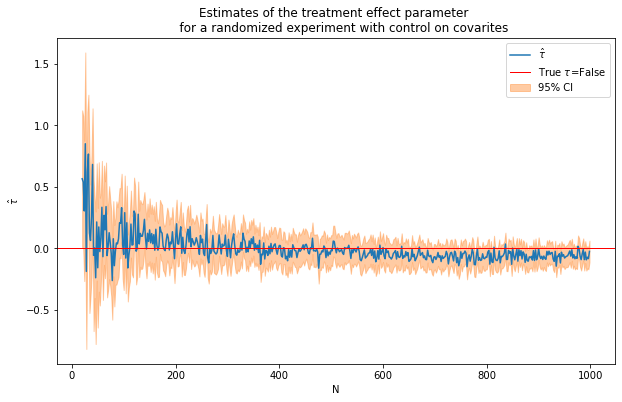

 30%|███████████████████████                                                       | 145/490 [00:00<00:00, 1442.03it/s]

Monte Carlo experiment ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 494.28it/s]

Treatment effect estimated: 
N=100: bias=-0.0076096746893462245, RMSE=0.11373293280259746, size=0.1
N=1000: bias=-0.0027151486211742827, RMSE=0.12447684589671434, size=0.0836734693877551


In [4]:
conf=False
flag_x_ctrl = True
flag_confounder_ctrl = True
flag_bias_ctrl = True
cap = """Estimates of the treatment effect parameter 
    for a randomized experiment with control on covarites"""
run_settings(conf, flag_x_ctrl=flag_x_ctrl, flag_bias_ctrl=flag_bias_ctrl, cap=cap)

## No control on covariates

 32%|████████████████████████▉                                                     | 157/490 [00:00<00:00, 1569.56it/s]

Simulating the DGP ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 509.53it/s]

Illustrating the DGP with a DAG ... ... 



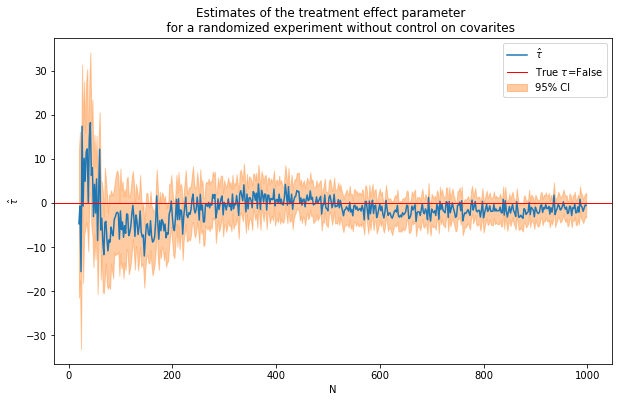

  0%|                                                                                          | 0/490 [00:00<?, ?it/s]

Monte Carlo experiment ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 511.26it/s]

Treatment effect estimated: 
N=100: bias=-1.4423524806827994, RMSE=3.5794793353101317, size=0.08163265306122448
N=1000: bias=-1.365264406639122, RMSE=3.340796930455502, size=0.08775510204081632


In [5]:
conf=False
flag_x_ctrl = False
flag_confounder_ctrl = True
flag_bias_ctrl = True
cap = """Estimates of the treatment effect parameter 
    for a randomized experiment without control on covarites"""
run_settings(conf, flag_x_ctrl=flag_x_ctrl, flag_bias_ctrl=flag_bias_ctrl, cap=cap)

The bias and RMSE is larger in case without control.

#  Experiments with  a confounder in the DGP

Example: when we exame the effect of new drugs, beside the treatment effect and health condition as covariates:

    - with control: also consider the effect of age which both affect health condition and outcome.
    - without control: ignore effect of age.



## control the confounder

 31%|███████████████████████▉                                                      | 150/490 [00:00<00:00, 1499.49it/s]

Simulating the DGP ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:01<00:00, 487.02it/s]


Illustrating the DGP with a DAG ... ... 



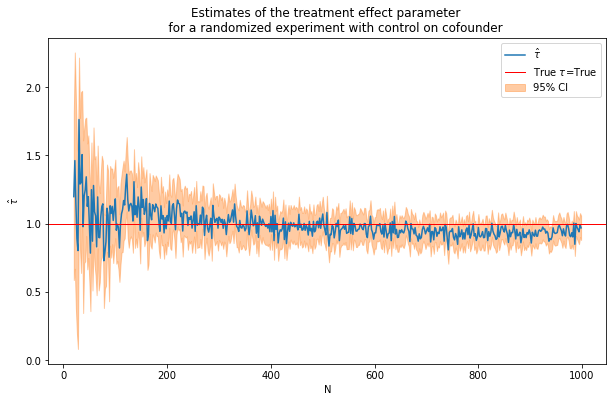

  0%|                                                                                          | 0/490 [00:00<?, ?it/s]

Monte Carlo experiment ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 490.66it/s]

Treatment effect estimated: 
N=100: bias=-0.010192163102224197, RMSE=0.10631096410204363, size=0.09183673469387756
N=1000: bias=-0.0080039759225566, RMSE=0.11379730181125858, size=0.11224489795918367


In [6]:
conf=True
flag_x_ctrl = True
flag_confounder_ctrl = True
flag_bias_ctrl = True
cap = """Estimates of the treatment effect parameter 
    for a randomized experiment with control on cofounder"""
run_settings(conf, flag_x_ctrl=flag_x_ctrl, flag_bias_ctrl=flag_bias_ctrl, cap=cap)


## No control on confounders

 30%|███████████████████████▋                                                      | 149/490 [00:00<00:00, 1477.94it/s]

Simulating the DGP ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 494.14it/s]


Illustrating the DGP with a DAG ... ... 



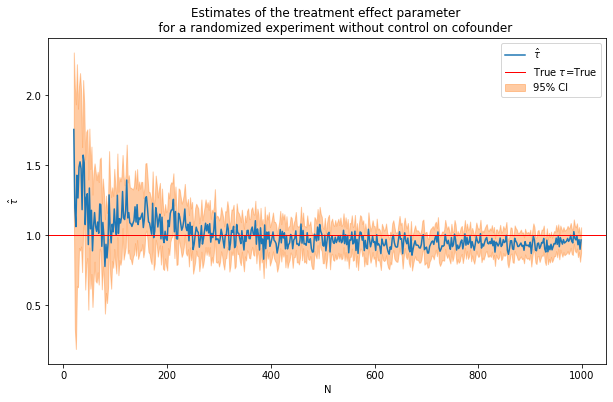

  0%|                                                                                          | 0/490 [00:00<?, ?it/s]

Monte Carlo experiment ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 493.06it/s]

Treatment effect estimated: 
N=100: bias=-0.0074565364853441595, RMSE=0.11382161312448723, size=0.09387755102040816
N=1000: bias=-0.009116539884977569, RMSE=0.10813218399081603, size=0.09387755102040816


In [7]:
conf=True
flag_x_ctrl = True
flag_confounder_ctrl = False
flag_bias_ctrl = True
cap = """Estimates of the treatment effect parameter 
    for a randomized experiment without control on cofounder"""
run_settings(conf, flag_x_ctrl=flag_x_ctrl, flag_bias_ctrl=flag_bias_ctrl, cap=cap)

The results are similar in both cases.

#  Experiments with  a selection bias in the DGP

Example: when we exame the effect of new drugs, beside the treatment effect and health condition and age:

    - with control: treatment is given randomly.
    - without control: treatment is given only to old people.



## control the selection bias

 31%|███████████████████████▉                                                      | 150/490 [00:00<00:00, 1490.76it/s]

Simulating the DGP ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:01<00:00, 482.75it/s]


Illustrating the DGP with a DAG ... ... 



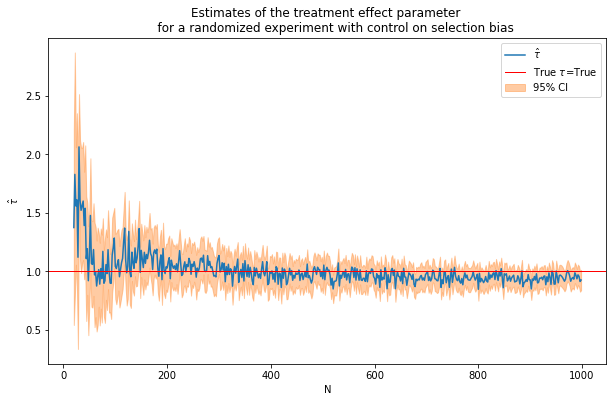

  0%|                                                                                          | 0/490 [00:00<?, ?it/s]

Monte Carlo experiment ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 490.87it/s]

Treatment effect estimated: 
N=100: bias=-0.007329053945138973, RMSE=0.11273928175640732, size=0.09591836734693877
N=1000: bias=-0.0058881878881769855, RMSE=0.11440422129474816, size=0.0836734693877551


In [8]:
conf=True
flag_x_ctrl = True
flag_confounder_ctrl = True
flag_bias_ctrl = True
cap = """Estimates of the treatment effect parameter 
    for a randomized experiment with control on selection bias"""
run_settings(conf, flag_x_ctrl=flag_x_ctrl, flag_bias_ctrl=flag_bias_ctrl, cap=cap)


## No control on selection bias

 30%|███████████████████████▍                                                      | 147/490 [00:00<00:00, 1469.50it/s]

Simulating the DGP ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:01<00:00, 479.52it/s]


Illustrating the DGP with a DAG ... ... 



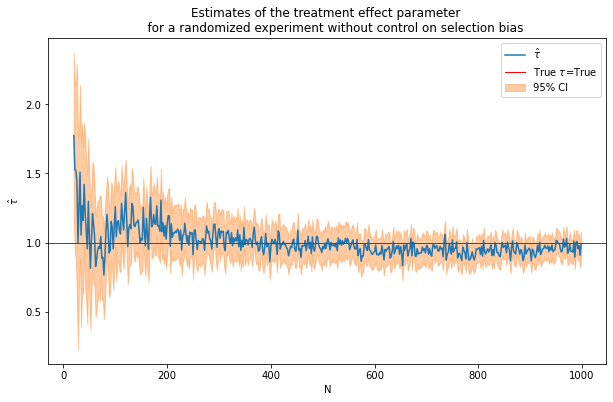

  0%|                                                                                          | 0/490 [00:00<?, ?it/s]

Monte Carlo experiment ... ... 



100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:01<00:00, 486.82it/s]

Treatment effect estimated: 
N=100: bias=0.002651639108807411, RMSE=0.1047886832051373, size=0.07346938775510205
N=1000: bias=0.002651639108807411, RMSE=0.1047886832051373, size=0.07346938775510205


In [9]:
conf=True
flag_x_ctrl = True
flag_confounder_ctrl = True
flag_bias_ctrl = False
cap = """Estimates of the treatment effect parameter 
    for a randomized experiment without control on selection bias"""
run_settings(conf, flag_x_ctrl=flag_x_ctrl, flag_bias_ctrl=flag_bias_ctrl, cap=cap)

The bias smaller in case without control.